<font size="10">Learning the Conjugacy Between the Tent and Sine Maps</font>

<font size="4">In this notebook we train an autoencoder neural network architecture to identify a conjugacy between the tent, $x_{n+1} = 2\min\{x_n,1-x_n\}$, and logistic, $y_{n+1} = \sin(\pi y_n)$, maps. The network simultaneously discovers an encoder, $\eta(x)$, and a decoder, $\rho(y)$, that approximate the conjugacy $h$ and its inverse $h^{-1}$. In this case the exact conjugacy is unknown and so we are using the autoencoder to approximate it.</font> 

<font size="4">This code was written by Jason J. Bramburger and accompanies the work in Section 6.2 of the book <i>Data-Driven Methods for Dynamic Systems</i>. We use Tensorflow 2.0 to build the neural network, which is imported as tf.

In [131]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

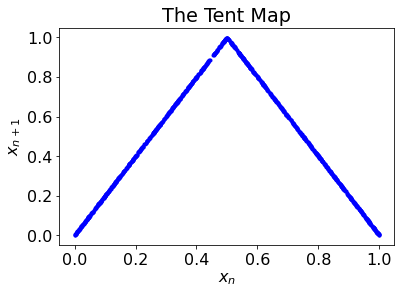

In [132]:
# Sample random points in the domain of the tent map [0,1]
N = 1000 # number of samples
xn = np.zeros((N,1))

for n in range(1,N):
    xn[n] = np.random.rand(1)
xnp1 = 2*np.minimum(xn, 1-xn) # forward iterate of the tent map

# Plot the tent map for visualization
plt.plot(xn,xnp1,'b.')
plt.xlabel('$x_n$',)
plt.ylabel('$x_{n+1}$')
plt.title('The Tent Map')
plt.rc('font', size= 16)

In [149]:
# Conjugacy neural network architecture

from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

# pi constant
pi = tf.constant(np.pi, dtype= 'float32')

class Conjugacy(Model):
  def __init__(self,
                 width = 100,
                 size_x = 1,
                 size_y = 1,
                 activation = 'selu',
                 numblksIn = 1,
                 numblksOut = 1,
                 l1reg = 1e-15,
                 l2reg = 1e-15,
                 **kwargs):
    super(Conjugacy, self).__init__()
    self.width = width 
    self.size_x = size_x
    self.size_y = size_y
    self.activation = activation
    self.numblksIn = numblksIn
    self.numblksOut = numblksOut
    self.l1reg = l1reg
    self.l2reg = l2reg
    self.initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None)
    
    # Encoder function 
    self.encoder = tf.keras.Sequential()
    
    for n in range(self.numblksIn): #adding more layers
        self.encoder.add(layers.Dense(width, activation=self.activation, 
                                      kernel_initializer=self.initializer, 
                                      kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                      bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    # Final layer to go to logistic map variables
    self.encoder.add(layers.Dense(self.size_y, activation=self.activation, 
                                  kernel_initializer=self.initializer,
                                  kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                  bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))

    # Decoder function
    self.decoder = tf.keras.Sequential()
    
    for n in range(self.numblksOut): #adding more layers
        self.decoder.add(layers.Dense(width, activation=self.activation, 
                                      kernel_initializer=self.initializer, 
                                      kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                      bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    # Final layer to go to tent map variables 
    self.decoder.add(tf.keras.layers.Dense(self.size_x, activation= self.activation, 
                                           kernel_initializer=self.initializer, 
                                           kernel_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg), 
                                           bias_regularizer=tf.keras.regularizers.L1L2(self.l1reg, self.l2reg)))
    
    
  def call(self, x):
    encoded = self.encoder(x)
    encoded_p1 = tf.math.sin(pi*encoded) # sine map step
    decoded = self.decoder(encoded_p1)
    
    # Encoder/Decoder loss
    x_recon = self.decoder(encoded)
    self.add_loss(tf.reduce_mean(tf.math.square(x - x_recon)))
    
    # f = rho of g of eta loss 
    xnp1 = 2*tf.math.minimum(x,1-x)
    self.add_loss(tf.reduce_mean(tf.math.square(decoded - xnp1)))
    
    # logistic map (g) loss
    xnp1_encoded = self.encoder(xnp1)
    self.add_loss(tf.reduce_mean(tf.math.square(encoded_p1 - xnp1_encoded)))
    
    return decoded

In [157]:
# Neural Network Parameters

width = 200 # width of each NN layer
size_x = 1 # number of variables in the tent map
size_y = 1 # number of variables in the logistic map
activation = 'selu' # nonlinear activation function at each NN layer
learning_rate = 0.000005
numblks_in = 5 # number of layers for the encoder NN
numblks_out = 5 # number of layers for the decoder NN

In [158]:
conjugacy = Conjugacy(width, size_x, size_y, activation, numblks_in, numblks_out)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = 200)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
conjugacy.compile(optimizer=optimizer, loss = 'mse') 

conjugacy.fit(xn, xnp1, callbacks = [callback], epochs = 5000)

Epoch 1/5000
32/32 [==============================] - 2s 4ms/step - loss: 4.2633
Epoch 2/5000
32/32 [==============================] - 0s 4ms/step - loss: 0.5071
Epoch 3/5000
32/32 [==============================] - 0s 4ms/step - loss: 0.0801
Epoch 4/5000
32/32 [==============================] - 0s 4ms/step - loss: 0.0584
Epoch 5/5000
32/32 [==============================] - 0s 4ms/step - loss: 0.0488
Epoch 6/5000
32/32 [==============================] - 0s 4ms/step - loss: 0.0422
Epoch 7/5000
32/32 [==============================] - 0s 4ms/step - loss: 0.0367
Epoch 8/5000
32/32 [==============================] - 0s 4ms/step - loss: 0.0320
Epoch 9/5000
32/32 [==============================] - 0s 4ms/step - loss: 0.0278
Epoch 10/5000
32/32 [==============================] - 0s 4ms/step - loss: 0.0243
Epoch 11/5000
32/32 [==============================] - 0s 4ms/step - loss: 0.0211
Epoch 12/5000
32/32 [==============================] - 0s 3ms/step - loss: 0.0184
Epoch 13/5000
32/32 [====

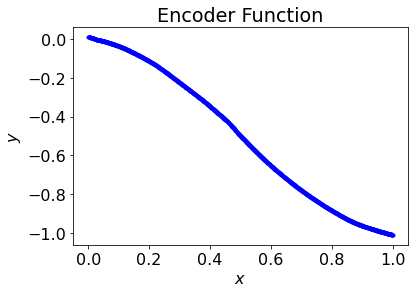

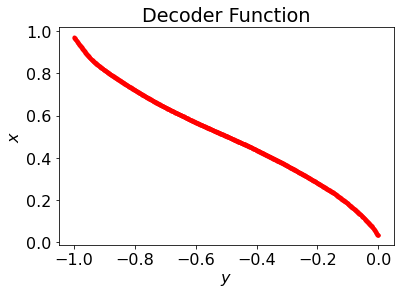

In [164]:
# View trained network

# Encoded variables
x = np.linspace(0,1,N)
y = conjugacy.encoder(x)

# Plot encoder/conjugacy function
fig = plt.figure()
plt.plot(x,y,'b.')
plt.xlabel('$x$',)
plt.ylabel('$y$')
plt.title('Encoder Function')
plt.rc('font', size= 16)

# Decoded variables
xdecode = conjugacy.decoder(-x)

# Plot decoder/inverse conjugacy function
fig2 = plt.figure()
plt.plot(-x,xdecode,'r.')
plt.xlabel('$y$',)
plt.ylabel('$x$')
plt.title('Decoder Function')
plt.rc('font', size= 16)

In [165]:
# Save plot and export to MATLAB
import scipy.io

# Save data as .mat file
scipy.io.savemat('Tent2Sine_Conj.mat', dict(x = x, y = y.numpy(), xdecode = xdecode.numpy()))
# This data is used in the MATLAB script make_plots.m to plot 
#      the encoder & decoder functions and compare them to the known conjugacy

In [161]:
# Save network config
#!mkdir -p saved_conjugacy_networks
conjugacy.save('saved_conjugacy_networks/Tent2Sine')

INFO:tensorflow:Assets written to: saved_conjugacy_networks/Tent2Sine/assets


In [162]:
# Load and view saved models
conjugacy = tf.keras.models.load_model('saved_conjugacy_networks/Tent2Sine')
conjugacy.summary()

# Compile the network
conjugacy.compile()

Model: "conjugacy_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_58 (Sequential)  (None, 1)                 161401    
                                                                 
 sequential_59 (Sequential)  (None, 1)                 161401    
                                                                 
Total params: 322,802
Trainable params: 322,802
Non-trainable params: 0
_________________________________________________________________
